<div class="alert alert-success">
Importing Libraries
</div>

# <div class="alert alert-warning">
# Steps:
# Importing necessary Libraries
# Creating S3 bucket
# Mapping train And Test Data in S3
# Mapping The path of the models in S3
# </div>

In [1]:
import sagemaker
import boto3
import os
from sagemaker.session import Session

In [3]:
# !pip install -U sagemaker

In [7]:
bucket_name = 'mldp-s8-sagemaker' # <--- CHANGE THIS VARIABLE TO A UNIQUE NAME FOR YOUR BUCKET
my_region = boto3.session.Session().region_name # set the region of the instance
print(my_region)

us-east-1


In [8]:
s3 = boto3.resource('s3')
try:
    if  my_region == 'us-east-1': # must be us-east-1. look at documentation. https://boto3.amazonaws.com/v1/documentation/api/latest/reference/services/s3.html#bucket
        s3.create_bucket(Bucket=bucket_name)
    print('S3 bucket created successfully')
except Exception as e:
    print('S3 error: ', e)

S3 bucket created successfully


In [9]:
# set an output path where the trained model will be saved
prefix = 'xgboost-as-a-built-in-algo'
output_path ='s3://{}/{}/output'.format(bucket_name, prefix)
print(output_path)

s3://mldp-s8-sagemaker/xgboost-as-a-built-in-algo/output


In [10]:
import pandas as pd
import urllib
try:
    urllib.request.urlretrieve ("https://d1.awsstatic.com/tmt/build-train-deploy-machine-learning-model-sagemaker/bank_clean.27f01fbbdf43271788427f3682996ae29ceca05d.csv", "bank_clean.csv")
    print('Success: downloaded bank_clean.csv.')
except Exception as e:
    print('Data load error: ',e)

try:
    model_data = pd.read_csv('./bank_clean.csv',index_col=0)
    print('Success: Data loaded into dataframe.')
except Exception as e:
    print('Data load error: ',e)

Success: downloaded bank_clean.csv.
Success: Data loaded into dataframe.


In [11]:
model_data.head(10)

,age,campaign,pdays,previous,no_previous_contact,not_working,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,...,day_of_week_fri,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_failure,poutcome_nonexistent,poutcome_success,y_no,y_yes
0,56,1,999,0,1,0,0,0,0,1,...,0,1,0,0,0,0,1,0,1,0
1,57,1,999,0,1,0,0,0,0,0,...,0,1,0,0,0,0,1,0,1,0
2,37,1,999,0,1,0,0,0,0,0,...,0,1,0,0,0,0,1,0,1,0
3,40,1,999,0,1,0,1,0,0,0,...,0,1,0,0,0,0,1,0,1,0
4,56,1,999,0,1,0,0,0,0,0,...,0,1,0,0,0,0,1,0,1,0
5,45,1,999,0,1,0,0,0,0,0,...,0,1,0,0,0,0,1,0,1,0
6,59,1,999,0,1,0,1,0,0,0,...,0,1,0,0,0,0,1,0,1,0
7,41,1,999,0,1,0,0,1,0,0,...,0,1,0,0,0,0,1,0,1,0
8,24,1,999,0,1,0,0,0,0,0,...,0,1,0,0,0,0,1,0,1,0
9,25,1,999,0,1,0,0,0,0,0,...,0,1,0,0,0,0,1,0,1,0


In [12]:
model_data.shape

(41188, 61)

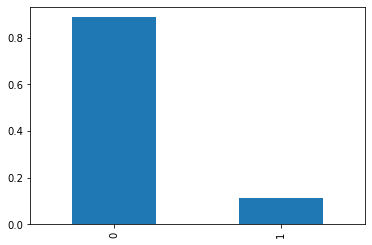

In [13]:
model_data.iloc[:, -1].value_counts(normalize=True).plot(kind='bar');

In [14]:
features = model_data.iloc[:, :-2]
target = model_data.iloc[:, -1]

In [15]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3, random_state=4299, stratify=target)
train_data  = pd.concat([y_train, X_train], axis='columns') # dependent feature should be the 1st column
test_data  = pd.concat([y_test, X_test], axis='columns')

In [16]:
test_data.head()

,y_yes,age,campaign,pdays,previous,no_previous_contact,not_working,job_admin.,job_blue-collar,job_entrepreneur,...,month_oct,month_sep,day_of_week_fri,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_failure,poutcome_nonexistent,poutcome_success
32613,0,27,1,999,0,1,0,1,0,0,...,0,0,0,1,0,0,0,0,1,0
23407,0,31,11,999,0,1,1,0,0,0,...,0,0,0,0,0,0,1,0,1,0
16241,0,30,3,999,0,1,0,1,0,0,...,0,0,0,0,0,1,0,0,1,0
37027,1,26,2,999,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0
18454,0,32,1,999,0,1,0,1,0,0,...,0,0,0,0,1,0,0,0,1,0


In [17]:
train_data.to_csv('train.csv', index=False, header=False)
test_data.to_csv('test.csv', index=False, header=False)

In [18]:
s3.Bucket(bucket_name).Object(os.path.join(prefix, 'train/train.csv')) .upload_file('train.csv')
s3.Bucket(bucket_name).Object(os.path.join(prefix, 'test/test.csv')) .upload_file('test.csv')

In [19]:
s3_train_path = sagemaker.TrainingInput(s3_data='s3://{}/{}/train'.format(bucket_name, prefix), content_type='csv')
s3_test_path = sagemaker.TrainingInput(s3_data='s3://{}/{}/test'.format(bucket_name, prefix), content_type='csv')

In [20]:
# this line automatically looks for the XGBoost image URI and builds an XGBoost container.
# specify the repo_version depending on your preference.
from sagemaker import image_uris
container = sagemaker.image_uris.retrieve('xgboost', 
                                          boto3.Session().region_name, 
                                          version='1.0-1')

In [21]:
# initialize hyperparameters
hyperparameters = {
        "max_depth":"5",
        "eta":"0.2",
        "gamma":"4",
        "min_child_weight":"6",
        "subsample":"0.7",
        "objective":"binary:logistic",
        "num_round":50
        }

In [22]:
# construct a SageMaker estimator that calls the xgboost-container
estimator = sagemaker.estimator.Estimator(image_uri=container, 
                                          hyperparameters=hyperparameters,
                                          role=sagemaker.get_execution_role(),
                                          instance_count=1, 
                                          instance_type='ml.m5.2xlarge', 
                                          volume_size=5, # 5 GB 
                                          output_path=output_path,
                                          use_spot_instances=True,
                                          max_run=300,
                                          max_wait=600)

In [23]:
estimator.fit({'train': s3_train_path,'validation': s3_test_path})

2022-02-27 17:22:49 Starting - Starting the training job...
2022-02-27 17:22:52 Starting - Launching requested ML instancesProfilerReport-1645982568: InProgress
.........
2022-02-27 17:24:44 Starting - Preparing the instances for training......
2022-02-27 17:25:45 Downloading - Downloading input data
2022-02-27 17:25:45 Training - Downloading the training image..INFO:sagemaker-containers:Imported framework sagemaker_xgboost_container.training
INFO:sagemaker-containers:Failed to parse hyperparameter objective value binary:logistic to Json.
Returning the value itself
INFO:sagemaker-containers:No GPUs detected (normal if no gpus installed)
INFO:sagemaker_xgboost_container.training:Running XGBoost Sagemaker in algorithm mode
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimiter of CSV input is ','
[17:26:01] 28831x59 matrix with 1701029 entries loaded from /opt/ml/input/data/train?format=csv&label_column=0&delim

In [24]:
xgb_predictor = estimator.deploy(initial_instance_count=1,instance_type='ml.m4.xlarge')

------!

In [26]:
from sagemaker.predictor import csv_serializer
import numpy as np
test_data_array = X_test.values #load the data into an array
xgb_predictor.serializer = csv_serializer # set the serializer type
predictions = xgb_predictor.predict(test_data_array).decode('utf-8') # predict!
predictions_array = np.fromstring(predictions[1:], sep=',') # and turn the prediction into an array
print(predictions_array.shape)

The csv_serializer has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


(12357,)


In [48]:
from sagemaker.predictor import csv_serializer
import numpy as np
test_data_array = X_test.values[:1000] #load the data into an array
xgb_predictor.serializer = csv_serializer # set the serializer type
predictions = xgb_predictor.predict(test_data_array).decode('utf-8')

The csv_serializer has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


In [49]:
predictions_array = np.fromstring(predictions[1:], sep=',')

In [50]:
cm = pd.crosstab(index=y_test[:1000], columns=np.round(predictions_array,0), rownames=['Actual'], colnames=['Predicted'])

In [51]:
cm

Predicted,0.0,1.0
Actual,,
0,859,20
1,93,28


In [28]:
cm = pd.crosstab(index=y_test, columns=np.round(predictions_array), rownames=['Actual'], colnames=['Predicted'])
tn = cm.iloc[0,0]; fn = cm.iloc[1,0]; tp = cm.iloc[1,1]; fp = cm.iloc[0,1]; p = (tp+tn)/(tp+tn+fp+fn)*100
print("\n{0:<20}{1:<4.1f}%\n".format("Overall Classification Rate: ", p))
print("{0:<15}{1:<15}{2:>8}".format("Predicted", "No Purchase", "Purchase"))
print("Actual")
print("{0:<15}{1:<2.0f}% ({2:<}){3:>6.0f}% ({4:<})".format("No Purchase", tn/(tn+fn)*100,tn, fp/(tp+fp)*100, fp))
print("{0:<16}{1:<1.0f}% ({2:<}){3:>7.0f}% ({4:<}) \n".format("Purchase", fn/(tn+fn)*100,fn, tp/(tp+fp)*100, tp))


Overall Classification Rate: 89.5%

Predicted      No Purchase    Purchase
Actual
No Purchase    91% (10783)    39% (182)
Purchase        9% (1111)     61% (281) 



In [52]:
try:
    sagemaker.Session().delete_endpoint(xgb_predictor.endpoint)
    #sagemaker.predictor.Predictor.delete_endpoint(xgb_predictor.endpoint, delete_endpoint_config=True)
    bucket_to_delete = boto3.resource('s3').Bucket(bucket_name)
    bucket_to_delete.objects.all().delete()
except:
    pass

The endpoint attribute has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
